In [82]:
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml

from data_loader import get_dataloaders
from model import SRCNN
from test import evaluate_model
from utils import load_config, parse_args
import logging


In [83]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import numpy as np

In [84]:
resample_scale_factor = 2
num_epochs = 20
filename = "test_metrics.csv"

In [85]:
config = load_config("config.json")

In [86]:
model_qualifier = "4xbutterfly"

In [87]:
model_folder = "modelButterflyScale4"

In [88]:
_, _, testloader = get_dataloaders(seed=42, resample_scale_factor=resample_scale_factor)

2025-02-26 16:36:24,342 - INFO - Using 22 images from ../data/train2017
2025-02-26 16:36:24,343 - INFO - Train dataset size: 18
2025-02-26 16:36:24,343 - INFO - Validation dataset size: 2
2025-02-26 16:36:24,344 - INFO - Test dataset size: 2


In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filename = f"test_metrics_{model_qualifier}.csv"
for i in range(1,num_epochs+1):
    model = SRCNN()
    #if file exists
    if not os.path.isfile(f'../{model_folder}/model_{i}_final.pt'):
        print("File not found!")
        continue
    model.load_state_dict(torch.load(f'../{model_folder}/model_{i}_final.pt', map_location=device))
    evaluate_model(model, testloader, config, filename)

100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


In [90]:
def validate_model(model, validloader, criterion, device, config):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)  # Accumulate loss

    avg_loss = total_loss / len(validloader.dataset)
    logging.info(f"Validation Loss: {avg_loss:.4f}")

    validation_metrics = evaluate_model(model, validloader, config)
    logging.info(validation_metrics)
    return validation_metrics

In [91]:
metric_file = f"../results/test_metrics_{model_qualifier}.csv"

In [92]:
loss_values = np.loadtxt("../modelOriginal/losses.csv", delimiter=",", usecols=0)
print(loss_values)

psnr_values = np.loadtxt(metric_file, usecols=1, skiprows=1, delimiter=",")
print(psnr_values)

ssim_values = np.loadtxt(metric_file, usecols=2, skiprows=1, delimiter=",")
print(ssim_values)

msssim_values = np.loadtxt(metric_file, usecols=3, skiprows=1, delimiter=",")
print(ssim_values)

[0.64535302 0.59264433 0.56473786 ... 0.00144396 0.00119906 0.00106422]
[25.9848 25.9696 25.8034 25.999  25.217  25.5291 25.2919 25.2305 22.7426
 24.6726 24.7202 24.9127 24.7216 24.7747 24.701  24.716  24.3136 24.3596
 25.1513 24.5139]
[0.8578 0.8714 0.8805 0.8884 0.884  0.8914 0.8901 0.8898 0.8805 0.8837
 0.8857 0.8908 0.8877 0.8915 0.8936 0.8867 0.8857 0.8864 0.8977 0.8913]
[0.8578 0.8714 0.8805 0.8884 0.884  0.8914 0.8901 0.8898 0.8805 0.8837
 0.8857 0.8908 0.8877 0.8915 0.8936 0.8867 0.8857 0.8864 0.8977 0.8913]


In [93]:
num_epochs = len(loss_values) #// 296
loss_x = np.arange(0, num_epochs + 1, 1 / 296)
loss_x = loss_x[:len(loss_values)]

num_epochs = len(psnr_values) 
psnr_x = np.arange(0, num_epochs + 1, 1 )
psnr_x = psnr_x[:len(psnr_values)]

num_epochs = len(ssim_values)
ssim_x = np.arange(0, num_epochs + 1, 1 )
ssim_x = ssim_x[:len(ssim_values)]

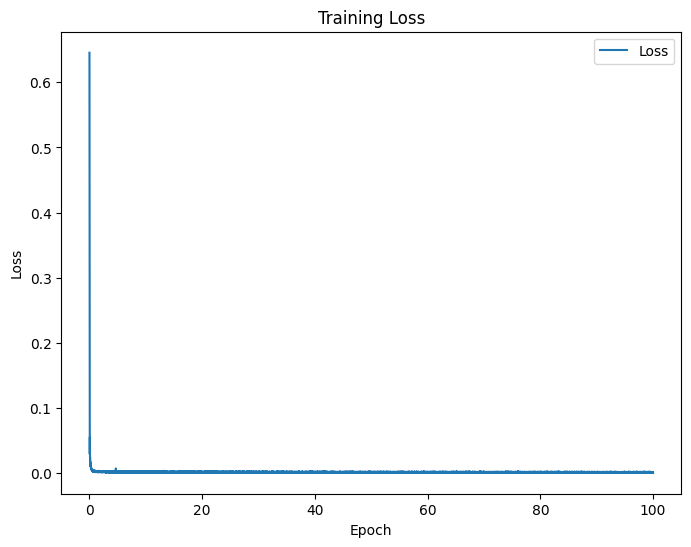

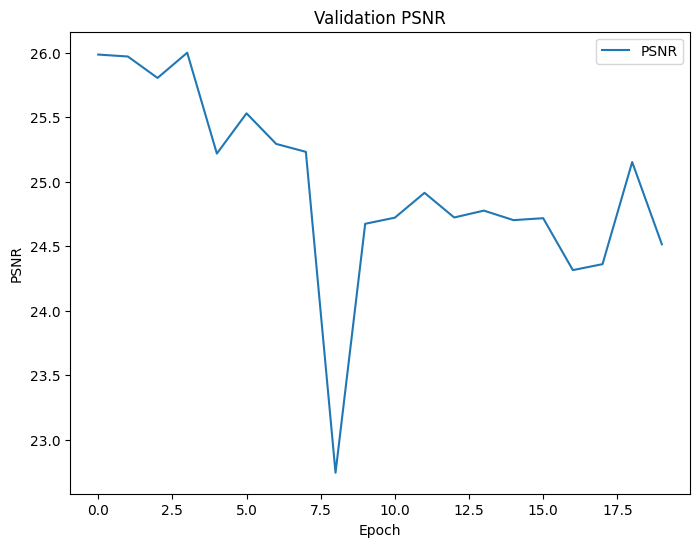

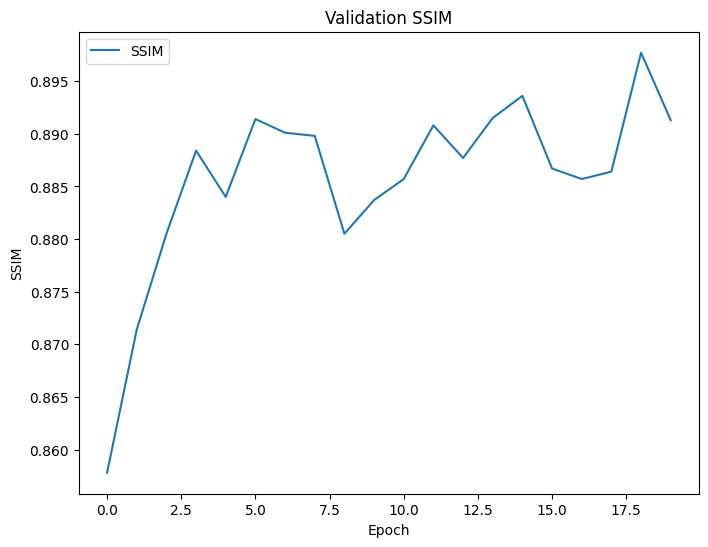

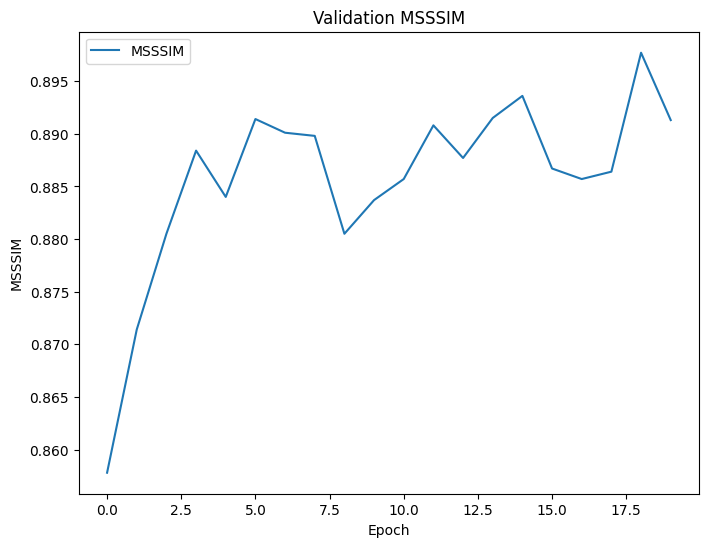

In [94]:
# Plot the loss values
plt.figure(figsize=(8, 6))
plt.plot(loss_x, loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig(f'../results/training_loss_{model_qualifier}.png')
plt.show()

# Plot the PSNR values
plt.figure(figsize=(8, 6))
plt.plot(psnr_x, psnr_values, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('Validation PSNR')
plt.legend()
plt.savefig(f'../results/validation_psnr_{model_qualifier}.png')
plt.show()

# Plot the SSIM values
plt.figure(figsize=(8, 6))
plt.plot(ssim_x, ssim_values, label='SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.legend()
plt.savefig(f'../results/validation_ssim_{model_qualifier}.png')
plt.show()


# Plot the MSSSIM values
plt.figure(figsize=(8, 6))
plt.plot(ssim_x, ssim_values, label='MSSSIM')
plt.xlabel('Epoch')
plt.ylabel('MSSSIM')
plt.title('Validation MSSSIM')
plt.legend()
plt.savefig(f'../results/validation_mssim_{model_qualifier}.png')
plt.show()